In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from fbprophet import Prophet
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
from pyspark.sql import SparkSession
import pyspark
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark = SparkSession.builder.master('local').getOrCreate()

In [3]:
df = pd.read_csv("weekly_sales.csv")
df.shape

(500, 3)

## BasicProcessing

In [4]:
df.head()

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      500 non-null    object 
 1   store_id  500 non-null    int64  
 2   sales     500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


Change date column to date type

In [6]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      500 non-null    datetime64[ns]
 1   store_id  500 non-null    int64         
 2   sales     500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.8 KB


In [7]:
# Chech for missing values
df.isnull().any()

date        False
store_id    False
sales       False
dtype: bool

In [8]:
# Unique values
df.nunique()

date         50
store_id     10
sales       500
dtype: int64

## Visualize the Time-series data

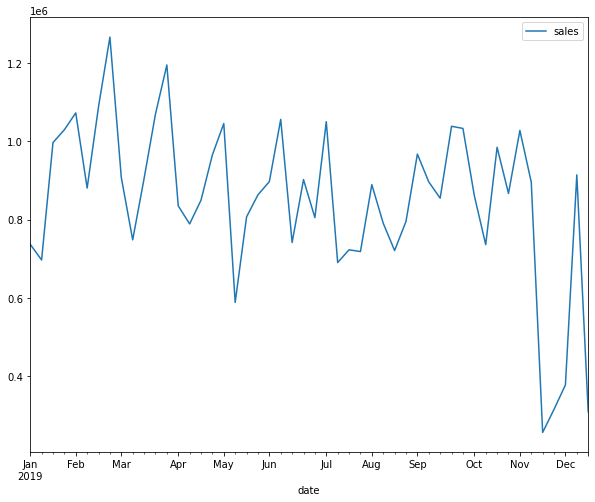

In [9]:
item_df = df.set_index('date')
item_df.query('store_id == 25')[['sales']].plot()
plt.show()

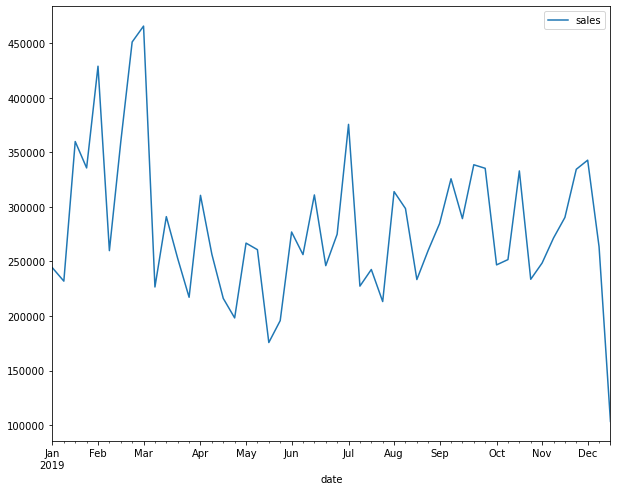

In [10]:
item_df.query('store_id == 41')[['sales']].plot()
plt.show()

## Analyze with Pyspark

In [11]:
sdf = spark.createDataFrame(df)
sdf.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_id: long (nullable = true)
 |-- sales: double (nullable = true)



In [12]:
sdf.show(5)

+-------------------+--------+-----------+
|               date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|   233711.0|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|   266455.0|
+-------------------+--------+-----------+
only showing top 5 rows



In [13]:
sdf.count()

500

In [14]:
sdf.select("store_id").groupBy('store_id').agg({'store_id': 'count'}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|      26|             50|
|      29|             50|
|      31|             50|
|      25|             50|
|      41|             50|
|      28|             50|
|      44|             50|
|      35|             50|
|      38|             50|
|      30|             50|
+--------+---------------+



In [15]:
## Same Query using SQL from a temporary view
sdf.createOrReplaceTempView("sales")

spark.sql("select store_id, count(*) from sales group by store_id order by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      25|      50|
|      26|      50|
|      28|      50|
|      29|      50|
|      30|      50|
|      31|      50|
|      35|      50|
|      38|      50|
|      41|      50|
|      44|      50|
+--------+--------+



In [16]:
# Prepare the data for prophet. It expects date as ds and target as Y

query = "SELECT store_id, date as ds, sum(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds"
spark.sql(query).show()

+--------+-------------------+-----------+
|store_id|                 ds|          y|
+--------+-------------------+-----------+
|      25|2019-01-06 00:00:00|736657.2267|
|      25|2019-01-13 00:00:00|696457.1717|
|      25|2019-01-20 00:00:00| 996876.875|
|      25|2019-01-27 00:00:00| 1029737.05|
|      25|2019-02-03 00:00:00|1072873.705|
|      25|2019-02-10 00:00:00|880462.4681|
|      25|2019-02-17 00:00:00| 1088756.78|
|      25|2019-02-24 00:00:00|1266928.313|
|      25|2019-03-03 00:00:00|907510.1217|
|      25|2019-03-10 00:00:00|747920.9824|
|      25|2019-03-17 00:00:00|904750.3158|
|      25|2019-03-24 00:00:00|1069857.589|
|      25|2019-03-31 00:00:00|1195574.314|
|      25|2019-04-07 00:00:00|834911.3333|
|      25|2019-04-14 00:00:00|788777.4167|
|      25|2019-04-21 00:00:00|849603.4333|
|      25|2019-04-28 00:00:00| 965521.165|
|      25|2019-05-05 00:00:00|1045632.688|
|      25|2019-05-12 00:00:00| 587768.245|
|      25|2019-05-19 00:00:00|806767.5946|
+--------+-

In [17]:
sdf.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [18]:
# Repartition the data

store_part = (spark.sql(query).repartition(spark.sparkContext.defaultParallelism,['store_id'])).cache()
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#1L, ds#83, y#84]
   +- InMemoryRelation [store_id#1L, ds#83, y#84], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#1L, 1), REPARTITION_WITH_NUM, [id=#147]
            +- *(3) Sort [store_id#1L ASC NULLS FIRST, ds#83 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#1L ASC NULLS FIRST, ds#83 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#143]
                  +- *(2) HashAggregate(keys=[store_id#1L, date#0], functions=[sum(sales#2)])
                     +- Exchange hashpartitioning(store_id#1L, date#0, 200), ENSURE_REQUIREMENTS, [id=#139]
                        +- *(1) HashAggregate(keys=[store_id#1L, date#0], functions=[partial_sum(sales#2)])
                           +- *(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [19]:
from pyspark.sql.types import *
result_schema = StructType([
    StructField('ds', TimestampType()),
    StructField('store_id', IntegerType()),
    StructField('y', DoubleType()),
    StructField('yhat', DoubleType()),
    StructField('yhat_upper', DoubleType()),
    StructField('yhat_lower', DoubleType())
])

In [20]:
# Create helper pandas UDF

from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_sales(store_pd):
    model = Prophet(interval_width=0.95, seasonality_mode='multiplicative', weekly_seasonality=True,yearly_seasonality=True)
    model.fit(store_pd)
    future_pd = model.make_future_dataframe(periods=5, freq='w')
    forecast_pd = model.predict(future_pd)
    f_pd = forecast_pd[['ds','yhat','yhat_upper','yhat_lower']].set_index('ds')
    st_pd = store_pd[['ds','store_id','y']].set_index('ds')
    result_pd = f_pd.join(st_pd,how='left')
    result_pd.reset_index(level=0, inplace=True)
    result_pd['store_id'] = store_pd['store_id'].iloc[0]
    return result_pd[['ds', 'store_id', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [21]:
from pyspark.sql.functions import current_date

results = (store_part.groupby('store_id').apply(forecast_sales).withColumn('training_date', current_date())).cache()
results.show()

C:\Users\gmnya\anaconda3\lib\site-packages\pyspark\sql\pandas\group_ops.py:81: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+-------------------+--------+-----------+------------------+------------------+-----------------+-------------+
|                 ds|store_id|          y|              yhat|        yhat_upper|       yhat_lower|training_date|
+-------------------+--------+-----------+------------------+------------------+-----------------+-------------+
|2019-01-06 00:00:00|      25|736657.2267| 712575.0694123247| 926190.8018713156|476890.3815495587|   2022-02-24|
|2019-01-13 00:00:00|      25|696457.1717|  743751.756898587| 986799.6669100102|517624.3482957306|   2022-02-24|
|2019-01-20 00:00:00|      25| 996876.875| 972909.8778095915|1215818.8814209858|736654.1118997311|   2022-02-24|
|2019-01-27 00:00:00|      25| 1029737.05|1034447.5557684809|1259981.8043756688|825715.9568992498|   2022-02-24|
|2019-02-03 00:00:00|      25|1072873.705| 986365.7266835545|1214353.6859575582|748603.0331347155|   2022-02-24|
|2019-02-10 00:00:00|      25|880462.4681|1016291.0609394275|1264708.2852233667|791041.526073451

In [22]:
results.coalesce(1)
print(results.count())
results.createOrReplaceTempView('forecasted')
spark.sql("SELECT store_id, count(*) FROM forecasted GROUP BY store_id").show()

550
+--------+--------+
|store_id|count(1)|
+--------+--------+
|      31|      55|
|      28|      55|
|      26|      55|
|      44|      55|
|      41|      55|
|      35|      55|
|      38|      55|
|      25|      55|
|      29|      55|
|      30|      55|
+--------+--------+



In [23]:
final_df = results.toPandas()
final_df

,ds,store_id,y,yhat,yhat_upper,yhat_lower,training_date
0,2019-01-06,25,7.366572e+05,7.125751e+05,9.261908e+05,476890.381550,2022-02-24
1,2019-01-13,25,6.964572e+05,7.437518e+05,9.867997e+05,517624.348296,2022-02-24
2,2019-01-20,25,9.968769e+05,9.729099e+05,1.215819e+06,736654.111900,2022-02-24
3,2019-01-27,25,1.029737e+06,1.034448e+06,1.259982e+06,825715.956899,2022-02-24
4,2019-02-03,25,1.072874e+06,9.863657e+05,1.214354e+06,748603.033135,2022-02-24
...,...,...,...,...,...,...,...
545,2019-12-22,44,NaN,6.265474e+04,1.289136e+05,-1491.142315,2022-02-24
546,2019-12-29,44,NaN,2.657442e+04,9.556476e+04,-37962.056217,2022-02-24
547,2020-01-05,44,NaN,8.801264e+03,6.964701e+04,-54326.524561,2022-02-24
548,2020-01-12,44,NaN,4.665900e+03,6.688102e+04,-55368.166694,2022-02-24


## Visualize Forecasted Sales

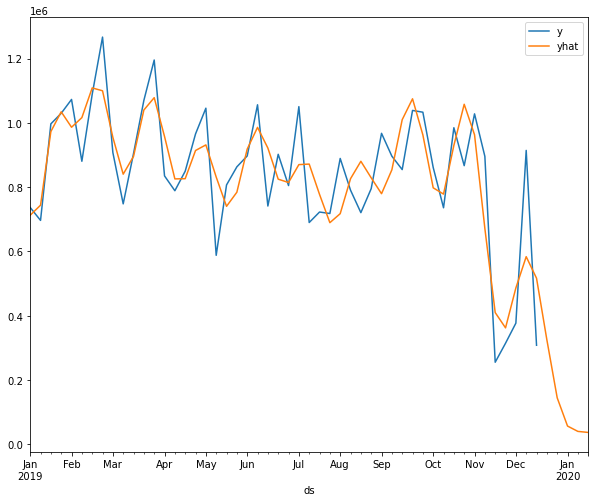

In [24]:
final_df = final_df.set_index('ds')
final_df.query('store_id == 25')[['y','yhat']].plot()
plt.show()

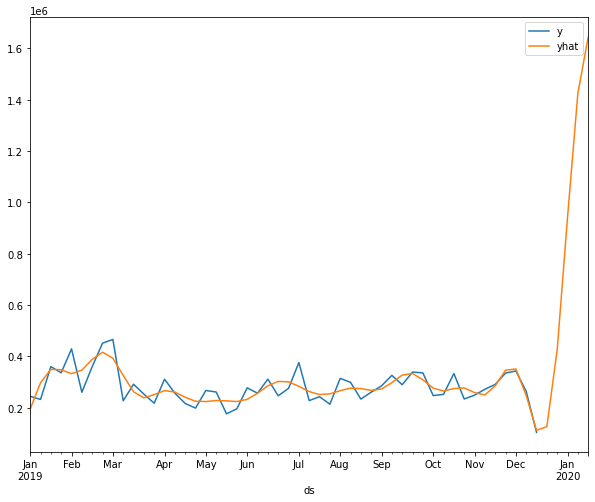

In [25]:
final_df.query('store_id == 41')[['y','yhat']].plot()
plt.show()